## __Plato Notebook 5a: Effects of sediment subduction on global plate motion__

Thomas Schouten, Whitney Behr, Edward Clennett and Thorsten Becker

This jupyter notebook provides a walkthrough of the Plato algorithm applied to calculate theoretical velocity increases resulting from sediment lubrication.

#### __0. Prepare Python__

First, we load the required packages and set the plotting parameters.

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

from plato.slabs import Slabs

In [34]:
# Plate reconstruction
reconstruction_name = "Muller2016" 

# Reconstruction ages of interest
ages = [0]

# Set directory with sample data
data_dir = os.path.abspath(os.path.join(os.getcwd(), "..", "sample_data", "M2016"))

# Set directory to save the results
results_dir = os.path.abspath(os.path.join(os.getcwd(), "..", "..", "output_notebooks", "05a-Effects_of_sediment_subduction"))

# Set directory to save the figures
figs_dir = os.path.abspath(os.path.join(os.getcwd(), "..", "..", "figures_notebooks", "05a-Effects_of_sediment_subduction"))

# Load seafloor ages
seafloor_age_grids = {}; continental_grids = {}
for age in ages:
    seafloor_age_grids[age] = xr.open_dataset(os.path.join(data_dir, "seafloor_age_grids", f"M2016_SeafloorAgeGrid_{age}Ma.nc"))
    seafloor_age_grids[age] = seafloor_age_grids[age].rename({"lat": "latitude", "lon": "longitude", "z": "seafloor_age"})

# Plotting parameters
cm2in = 0.3937008
fig_width = 18*cm2in*2; fig_height_graphs = 8*cm2in*2; fig_height_maps = 10.5*cm2in*2
plt.rcParams["font.size"] = 12
plt.rcParams["font.family"] = "Arial"
title_fontsize = 20
plot_times = [45, 60, 75, 90]
projection = ccrs.Robinson(central_longitude = 160) 
annotations = ["a", "b", "c", "d"]

#### __1.1 Slab pull calculation__

In the Plato algorithm the effect of sediment subduction on the slab pull torque is implemented as an interface term that scales logarithmically with the fraction of the interface that is occupied by sediments, whereby the sediment fraction is calculated by dividing the sediment thickness by the shear zone width and assuming the rest is filled with basalt (i.e. for a shear zone width of 2 km, a slab with a 600 m thick sediment cover will be result in an interface that is filled with 30% sediment and 70% basalt).

The below cell contains the function to calculate slab pull torque:

In [3]:
def compute_interface_term(sediment_fraction, C=0.0321):
    """
    Function to calculate the interface term that accounts for resisting forces at the subduction interface.
    These forces are i) shearing along the plate interface, ii) bending of the slab, and iii) vertical resistance to slab sinking.
    The value of C0 is obtained from the optimisation of the slab pull force (see below).

    :param sediment_fraction:   fraction of the subduction interface occupied by sediments
    :type sediment_fraction:    float, array
    :param C0:                  constant that scales the interface term
    :type C0:                   float

    :return:                    interface term for the slab pull force
    :rtype:                     float, array
    """
    # Calculate interface term for all components of the slab pull force
    interface_term = C * (11 - 10**(1-sediment_fraction))
    
    return interface_term

def calculate_slab_thickness(ages):
    """
    Function to calculate thickness of slab as a function of oceanic age
    """
    # Constants
    kappa = 1e-6                            # thermal diffusivity [m2/s]
    ma2s = 1e6 * 365.25 * 24 * 60 * 60      # Ma to s

    return 2.32 * np.sqrt(kappa * ages * ma2s)

def calculate_slab_pull_force(slab_thickness):
    """
    Function to calculate the slab pull force.

    :param slab_thickness:      thickness of the slab [m]
    :type slab_thickness:       float, array

    :return:                    slab pull force [N]
    :rtype:                     float, array
    """
    # Set mechanical properties
    g = 9.81                        # acceleration due to gravity [m/s2]
    dT = 1200                       # mantle-surface T contrast [K]
    alpha = 3e-5                    # thermal expansivity [K-1]
    rho0 = 3300                     # reference mantle density  [kg/m3]
    depth = 700e3                   # depth of slab [m]
    drho_slab = rho0 * alpha * dT   # slab density contrast [kg/m3]

    # Calculate slab pull force
    return slab_thickness * depth * drho_slab * g


The below cells calculate the slab pull force for a range of plausible plate ages and sediment fractions in the interface.

In [4]:
# Set ranges for age and sediment fraction
age_range = np.linspace(0, 250., 1001)
sediment_fraction_range = np.linspace(0, 1, 1001)

# Create meshgrid
ages, sediment_fractions = np.meshgrid(age_range, sediment_fraction_range)

In [5]:
# Calculate slab thickness and slab pull force
slab_thickness = calculate_slab_thickness(ages)

# Calculate slab pull force
slab_pull_force = calculate_slab_pull_force(slab_thickness)

# Calculate interface term and effective slab pull force
interface_term = {}; slab_pull_force_eff = {}
for arc_type in ["continental", "oceanic"]:
    interface_term[arc_type] = compute_interface_term(sediment_fractions)
    
    if arc_type == "continental":
        interface_term[arc_type] /= 1.23
        
    slab_pull_force_eff[arc_type] = slab_pull_force * interface_term[arc_type]

The below cell visualises the value of the interface term as a function of sediment thickness and slab age, like figure S1.

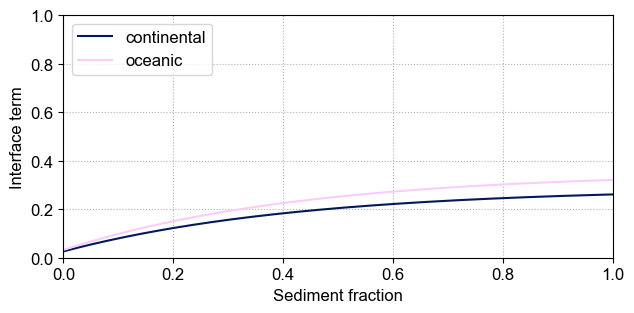

In [6]:
colours = plt.get_cmap("cmc.batlow")(np.linspace(0, 1, 2))
fig, ax = plt.subplots(1, 1, figsize=(fig_width/2, fig_height_graphs/2))
for i, arc_type in enumerate(["continental", "oceanic"]):
    ax.plot(sediment_fraction_range, interface_term[arc_type][:, 0], label=arc_type, color=colours[i])
ax.set_xlabel("Sediment fraction")
ax.set_ylabel("Interface term")
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.grid(ls=":")
# ax.set_yscale("log")
ax.legend(loc="upper left")#, labels=["Continental", "Oceanic"])
fig.savefig(os.path.join(figs_dir, "Sediment_thickness_vs_Interface_term.png"), bbox_inches="tight", dpi=300)
plt.show()

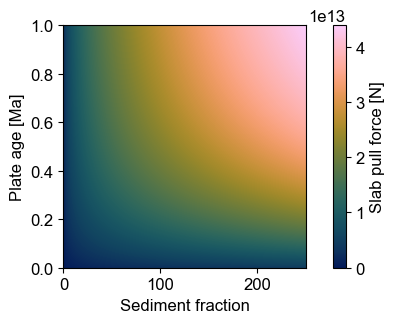

In [21]:
fig, ax = plt.subplots(figsize=(fig_width/2, fig_height_graphs/2))

for arc_type in ["continental", "oceanic"]:
    c = ax.imshow(
        slab_pull_force_eff[arc_type],
        cmap="cmc.batlow",
        extent=[0,250,1,0],
        )
    ax.set_aspect(2.5e2)
    ax.set_xlabel("Sediment fraction")
    ax.set_ylabel("Plate age [Ma]")
    ax.invert_yaxis()
    fig.colorbar(c, label="Slab pull force [N]", aspect=20)
    fig.savefig(os.path.join(figs_dir, f"Effective_slab_pull_force_{arc_type}.png"), bbox_inches="tight", dpi=300)
    plt.show()

### 1.2 Biogenic sedimentation

Modern-day biogenic sediment thickness is a function of nutrient availability and (in the case of carbonate sediments, the dominant biogenic sediments in the modern day) CCD depth. The former varies as a function of ocean currents but tends to have a maximum centred on the equator (equatorial bulge sedimentation), whereas the latter varies as a function of ocean chemistry that fluctuates throughout geologic time.

These two end-member distributions are approximated using two functions.

In [8]:
# Generate a Gaussian sediment distribution centred around the equator
def equatorial_sediments(seafloor_ages, latitudes, thickness):
    """
    Generates a sediment distribution as a Gaussian centred around the equator
    
    :param seafloor_ages:   age grid of the seafloor
    :type seafloor_ages:    np.array or xr.DataArray
    :param latitudes:       latitudes of grid
    :type latitudes:        array-like
    :param thickness:       thickness of sediments at the equator on 1 Ma old lithosphere
    :type thickness:        float or int

    :return:                grid with thickness of fluctuating sediments
    :rtype:                 np.array or xr.DataArray
    """
    # Calculate sediment thickness as a function of latitude and plate age
    grid = np.sqrt(seafloor_ages) * thickness * np.exp(-(latitudes**2) / (2 * 10**2))

    return grid

# Generate a sediment distribution that fluctuates as a function of age
def fluctuating_sediments(seafloor_ages, phase, thicknesses, periods):
    """
    Generates a sediment distribution that fluctuates with time

    :param seafloor_ages:   age grid of the seafloor
    :type seafloor_ages:    np.array or xr.DataArray
    :param phase:           phase shift of the sine wave describing the fluctuations in sedimentation
    :type phase:            float or int
    :param thicknesses:     amplitude of the sine wave describing the fluctuations in sedimentation
    :param periods:         period of the sine wave describing the fluctuations in sedimentation

    :return:                grid with thickness of fluctuating sediments
    :rtype:                 np.array or xr.DataArray
    """
    grid = np.zeros_like(seafloor_ages)
    for thickness, period in zip(thicknesses, periods):
        grid += thickness * np.sin(seafloor_ages * 2 * np.pi / period + phase * period)

    grid = np.where(grid < 0, 0, grid)

    return grid

# Calculate sediment distribution from GlobSed (Straume et al., 2019)
def globsediments(seafloor_ages, latitudes, parameters=(52, -2.46, 0.045)):
    """
    Generates a sediment distribution as a function of age and latitude based on GlobSed data

    :param seafloor_ages:   age grid of the seafloor
    :type seafloor_ages:    np.array or xr.DataArray
    :param latitudes:       latitudes of grid
    :type latitudes:        array-like
    :param thicknesses:     thickness of sediments at the equator on 1 Ma old lithosphere
    :type thicknesses:      array-like

    :return:                grid with thickness of fluctuating sediments
    :rtype:                 np.array or xr.DataArray
    """
    # Calculate sediment thickness as a function of latitude and plate age
    grid = np.sqrt(seafloor_ages) * (parameters[0] + parameters[1] * np.abs(latitudes) + parameters[2] * np.abs(latitudes) ** 2)

    return grid

In [9]:
# Set ranges for age and latitude
age_range = np.linspace(0, 250, 1001)
latitude_range = np.linspace(-90, 90, 1001)

# Create meshgrid
ages, latitudes = np.meshgrid(age_range, latitude_range)

# Calculate globsed distribution
globsed_thicknesses = globsediments(ages, latitudes)

# Calculate equatorial sediment distribution
equatorial_bulge_sediment_thicknesses = equatorial_sediments(ages, latitudes, 75)

# Set thicknesses and periods for fluctuating sediments
carbonate_sediment_thicknesses = [30, 300]
carbonate_sediment_periods = [5, 50]

# Calculate fluctuating sediment distribution
carbonate_sediment_thicknesses = fluctuating_sediments(age_range, 0, carbonate_sediment_thicknesses, carbonate_sediment_periods)

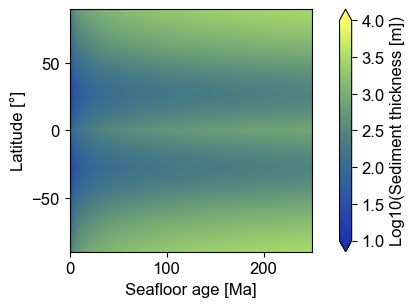

In [10]:
fig, ax = plt.subplots(figsize=(fig_width/2, fig_height_graphs/2))
c = ax.imshow(np.log10(globsed_thicknesses), cmap="cmc.imola", extent=[0,250,-90,90], vmin=1, vmax=4)
ax.set_aspect(250/180)
ax.set_xlabel("Seafloor age [Ma]")
ax.set_ylabel("Latitude [°]")
fig.colorbar(c, label="Log10(Sediment thickness [m])", aspect=20, extend="both")
fig.savefig(os.path.join(figs_dir, "Globsediment_thickness.png"), bbox_inches="tight", dpi=300)
plt.show()

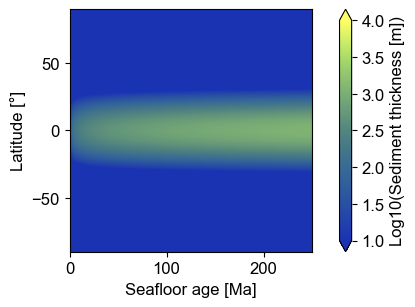

In [11]:
fig, ax = plt.subplots(figsize=(fig_width/2, fig_height_graphs/2))
c = ax.imshow(np.log10(equatorial_bulge_sediment_thicknesses), cmap="cmc.imola", extent=[0,250,-90,90], vmin=1, vmax=4)
ax.set_aspect(250/180)
ax.set_xlabel("Seafloor age [Ma]")
ax.set_ylabel("Latitude [°]")
fig.colorbar(c, label="Log10(Sediment thickness [m])", aspect=20, extend="both")
fig.savefig(os.path.join(figs_dir, "Equatorial_sediment_thickness.png"), bbox_inches="tight", dpi=300)
plt.show()

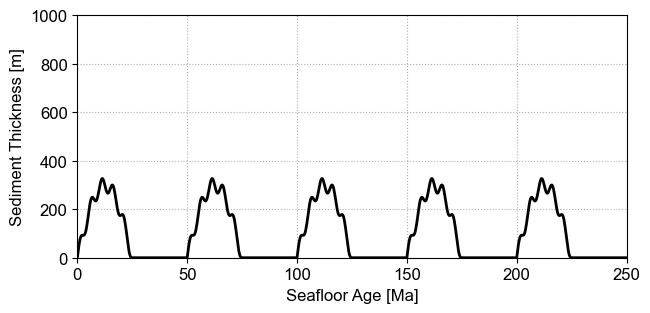

In [12]:
fig, ax = plt.subplots(figsize=(fig_width/2, fig_height_graphs/2))
ax.plot(age_range, carbonate_sediment_thicknesses, color="black", lw=2)
ax.set_xlim(0, 250)
ax.set_ylim(0, 1e3)
ax.grid(ls=":")
ax.set_xlabel("Seafloor Age [Ma]")
ax.set_ylabel("Sediment Thickness [m]")

fig.savefig(os.path.join(figs_dir, "Carbonate_sediment_thickness.png"), bbox_inches="tight", dpi=300)

In [28]:
# Set up PlateTorques objects
M2016_slabs = Slabs(
    reconstruction_name = "Muller2016",
    ages = [0],
    files_dir = results_dir,
    rotation_file = os.path.join(data_dir, "gplates_files", "M2016_rotations_Lr-Hb.rot"),
    topology_file = os.path.join(data_dir, "gplates_files", "M2016_topologies.gpml"),
    polygon_file = os.path.join(data_dir, "gplates_files",  "M2016_static_polygons.gpml"),
)

Loading slab data: 100%|██████████| 1/1 [00:00<00:00,  1.62it/s]


In [35]:
M2016_slabs.sample_slab_seafloor_ages(grids=seafloor_age_grids)
M2016_slabs.calculate_velocities()
M2016_slabs.calculate_slab_pull_force()

Calculating slab pull forces: 100%|██████████| 1/1 [00:00<00:00, 80.72it/s]


In [36]:
def haversine(lat1, lon1, lat2, lon2):
    """
    Calculate the Haversine distance between two sets of points on Earth.

    :param lat1:    Latitude of the first point in degrees.
    :type lat1:     float
    :param lon1:    Longitude of the first point in degrees.
    :type lon1:     float
    :param lat2:    Latitude of the second point in degrees.
    :type lat2:     float
    :param lon2:    Longitude of the second point in degrees.
    :type lon2:     float

    :return:        The Haversine distance between the two points.
    :rtype:         float
    """
    # Convert latitude and longitude from degrees to radians
    lat1 = np.deg2rad(lat1)
    lon1 = np.deg2rad(lon1)
    lat2 = np.deg2rad(lat2)
    lon2 = np.deg2rad(lon2)

    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    return c

In [37]:
# Load ref. (2012) data
trench_sediment_thickness = pd.read_excel(os.path.join(data_dir, "present_day_sediments", "heuret2012_data.xlsx"))

# Add ref et al. (2012) data (which is in km!!) to the sediment thickness column in slabs
for age in M2016_slabs.ages:
    for case in M2016_slabs.cases:
        for i, _ in enumerate(M2016_slabs.data[age][case].lat):
            distance_to_segments = haversine(
                M2016_slabs.data[age][case].loc[i, "lat"],
                M2016_slabs.data[age][case].loc[i, "lon"],
                trench_sediment_thickness.Latitude,
                trench_sediment_thickness.Longitude
            )
            M2016_slabs.data[age][case].loc[i, "sediment_thickness"] = trench_sediment_thickness["Sediment thickness"][distance_to_segments.idxmin()] * 1e3

In [38]:
slab_age = M2016_slabs.data[0]["ref"][
    (M2016_slabs.data[0]["ref"].slab_seafloor_age != 0) & 
    (pd.notna(M2016_slabs.data[0]["ref"].slab_seafloor_age)) & 
    (M2016_slabs.data[0]["ref"].continental_arc == True)].slab_seafloor_age.values
slab_sediment_thickness = M2016_slabs.data[0]["ref"][
    (M2016_slabs.data[0]["ref"].slab_seafloor_age != 0) & 
    (pd.notna(M2016_slabs.data[0]["ref"].slab_seafloor_age)) & 
    (M2016_slabs.data[0]["ref"].continental_arc == True)].sediment_thickness.values
slab_convergence_rate = M2016_slabs.data[0]["ref"][
    (M2016_slabs.data[0]["ref"].slab_seafloor_age != 0) & 
    (pd.notna(M2016_slabs.data[0]["ref"].slab_seafloor_age)) & 
    (M2016_slabs.data[0]["ref"].continental_arc == True)].convergence_velocity_mag.values

# Fit a power law to the data
ages = np.arange(0, 250, 1)
rates = np.arange(0, 20, 0.1)
age_thicknesses = ages**(1.5) * 2.5
rate_thicknesses = -1.5e2 * rates + 2.5e3

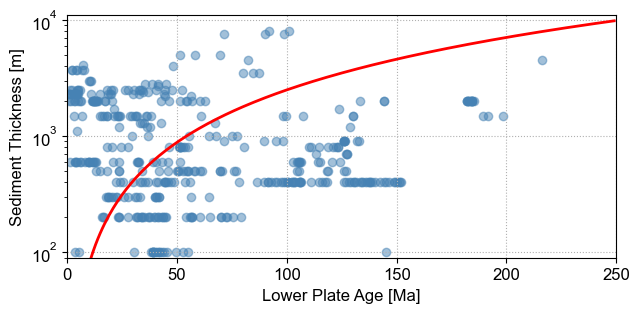

In [46]:
# Plot the scatter plot and the fitted line
fig, ax = plt.subplots(figsize=(fig_width*.5, fig_height_graphs*.5))
ax.scatter(slab_age, slab_sediment_thickness, c="steelblue", alpha=.5)
ax.semilogy()
ax.plot(ages, age_thicknesses, color="red", lw=2)
ax.set_xlim(0, 250)
ax.set_ylim(90, 11000)
ax.grid(ls=":")
ax.set_xlabel("Lower Plate Age [Ma]")
ax.set_ylabel("Sediment Thickness [m]")

fig.savefig(os.path.join(figs_dir, "Sediment_thickness_vs_Lower_plate_age.png"), bbox_inches="tight", dpi=300)

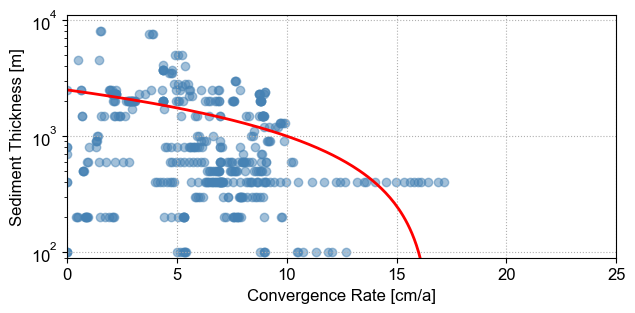

In [48]:
# Plot the scatter plot and the fitted line
fig, ax = plt.subplots(figsize=(fig_width*.5, fig_height_graphs*.5))
ax.scatter(slab_convergence_rate, slab_sediment_thickness, c="steelblue", alpha=.5)
ax.plot(rates, rate_thicknesses, color="red", lw=2)
ax.semilogy()
ax.set_xlim(0, 25)
ax.set_ylim(90, 11000)
ax.grid(ls=":")
ax.set_xlabel("Convergence Rate [cm/a]")
ax.set_ylabel("Sediment Thickness [m]")

plt.savefig(os.path.join(figs_dir, "Sediment_thickness_vs_Convergence_rate.png"), bbox_inches="tight", dpi=300)